In [1]:
from torchvision import transforms, models
import torch.optim as optim
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os

os.environ['PYTORCH_MPS_HIGH_WATERMARK_RATIO'] = '0.0'
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
MAX_SIZE = 400
def load_image(img_path, max_size=MAX_SIZE, shape=None):

    image = Image.open(img_path)
    if shape is not None:
        image = image.resize(shape, resample=Image.Resampling.LANCZOS)
    image.convert('RGB')

    size = min(max_size, max(image.size))

    in_transform = transforms.Compose([
        transforms.Resize(size),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406),
                             (0.229, 0.224, 0.225))])

    # discard the transparent, alpha channel (that's the :3) and add the batch dimension
    image = in_transform(image)[:3, :, :].unsqueeze(0)
    return image

def im_convert(tensor):
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1, 2, 0)
    image = image * np.array((0.229, 0.224, 0.225)) + \
        np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)
    return image

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, use_leaky_relu=True):
        super(ConvBlock, self).__init__()
        self.reflection_pad = nn.ReflectionPad2d(kernel_size//2)
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size)
        self.batchnorm = nn.BatchNorm2d(out_channels)
        self.activation = nn.LeakyReLU(negative_slope=0.2, inplace=True) if use_leaky_relu else nn.ReLU()

    def forward(self, x):
        x = self.reflection_pad(x)
        x = self.conv(x)
        x = self.batchnorm(x)
        x = self.activation(x)
        return x

class JoinBlock(nn.Module):
    def __init__(self, in_channels) -> None:
        super(JoinBlock, self).__init__()
        self.bacthnorm1 = nn.BatchNorm2d(in_channels)
        self.bacthnorm2 = nn.BatchNorm2d(8)

    def forward(self, x1, x2):
        # Resize x1 to the size of x2 for concatenation
        x1 = self.bacthnorm1(x1)
        x2 = self.bacthnorm2(x2)
        upsampled_x1 = F.interpolate(x1, size=x2.shape[2:], mode='bilinear', align_corners=True)
        return torch.cat((upsampled_x1, x2), dim=1)

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        # Define the convolutional blocks for each level
        self.conv_block_1 = self._make_layers(3, 8)
        self.conv_block_2 = self._make_layers(3, 8)
        self.conv_block_3 = self._make_layers(3, 8)
        self.conv_block_4 = self._make_layers(3, 8)
        self.conv_block_5 = self._make_layers(3, 8)

        # Define the join blocks
        self.join_block_1 = JoinBlock(8)
        self.join_block_2 = JoinBlock(16)
        self.join_block_3 = JoinBlock(24)
        self.join_block_4 = JoinBlock(32)

        # Define the post-join convolutional blocks
        self.post_join_conv_block_1 = self._make_layers(16, 16)
        self.post_join_conv_block_2 = self._make_layers(24, 24)
        self.post_join_conv_block_3 = self._make_layers(32, 32)
        self.post_join_conv_block_4 = self._make_layers(40, 40)

        # Final convolutional layer to create the output texture image
        self.final_conv = ConvBlock(40, 3, 1, use_leaky_relu=True)

    def _make_layers(self, in_channels, out_channels):
        layers = [
            ConvBlock(in_channels, out_channels, 3),
            ConvBlock(out_channels, out_channels, 3),
            ConvBlock(out_channels, out_channels, 1)
        ]
        return nn.Sequential(*layers)

    def forward(self, x):
        
        # Process the input through each convolutional block at each scale
        conv1 = self.conv_block_1(x)
        conv2 = self.conv_block_2(F.interpolate(x, scale_factor=1/2, mode='bilinear', align_corners=True))
        conv3 = self.conv_block_3(F.interpolate(x, scale_factor=1/4, mode='bilinear', align_corners=True))
        conv4 = self.conv_block_4(F.interpolate(x, scale_factor=1/8, mode='bilinear', align_corners=True))
        conv5 = self.conv_block_5(F.interpolate(x, scale_factor=1/16, mode='bilinear', align_corners=True))

        # Perform the joining operations
        join1 = self.join_block_1(conv5, conv4)
        join2 = self.join_block_2(self.post_join_conv_block_1(join1), conv3)
        join3 = self.join_block_3(self.post_join_conv_block_2(join2), conv2)
        join4 = self.join_block_4(self.post_join_conv_block_3(join3), conv1)

        # Final processing after the last join operation
        result = self.post_join_conv_block_4(join4)

        # Create the final output texture image
        texture = self.final_conv(result)
        return texture

In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

generator = Generator().to(device)
state_dict = torch.load('models\model-autumn-texture.pth')
generator.load_state_dict(state_dict)

<All keys matched successfully>

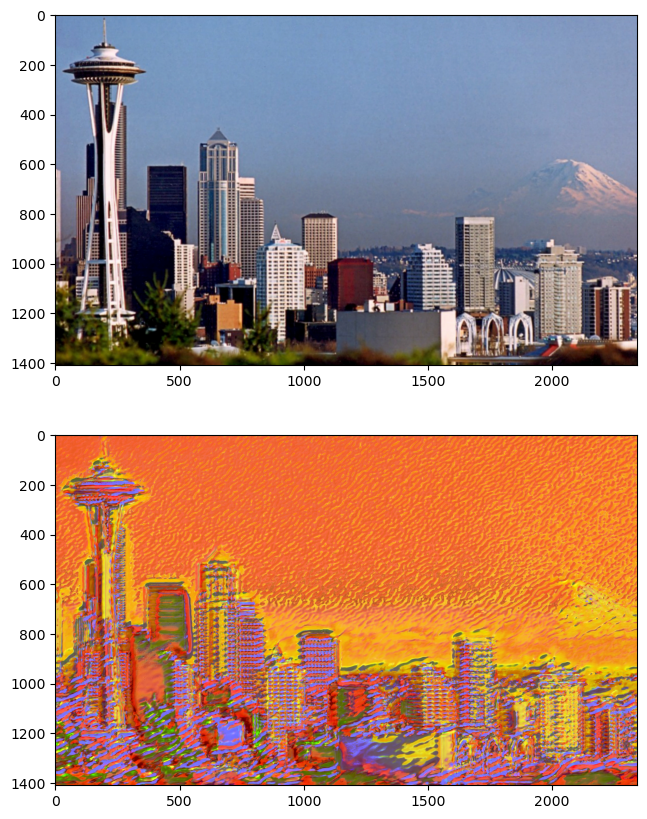

In [4]:
content_image = load_image('images/space_needle.jpg',10000).to(device)
with torch.no_grad():
    stylized_image = generator(content_image)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 10)) 
ax1.imshow(im_convert(content_image))
ax2.imshow(im_convert(stylized_image))